### Imports

In [165]:
import pandas as pd
import os
from functions.draw_cards import draw_cards, translate_vecs_to_cards
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter


print(os.getcwd())


/Users/peterlucas/repos/set-simulation/src


### Load data

In [9]:
simul_data = pd.read_pickle("../artifacts/set_simul_20220218_740859.pkl")

### Frequency of number of SETs from cards on the table
*When there are at least 12 cards on the table*

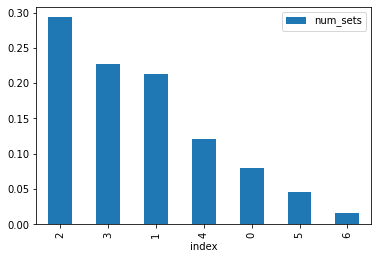

In [187]:
(
    simul_data.query("num_cards_table >= 12")["num_sets"]
    .value_counts(normalize=True)
    .reset_index()
    .query("num_sets >= 0.01")
    .plot(kind="bar", x="index", y="num_sets")
)
plt.show()

### Dimension sameness in SETs
There are 4 dimensions on each card (number, color, shape, pattern). Counting the average number of dimensions that are the same across sets in a game.

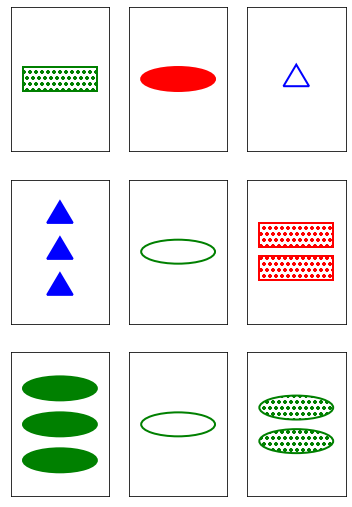

In [50]:
all_sets = simul_data[["sets"]].iloc[0, 0][0]
selected_sets = all_sets[:3, :, :].reshape(-1, 4)
draw_cards(translate_vecs_to_cards(selected_sets))

In [68]:
def count_same_dimensions(set_):
    """
    If the set of numbers in a SET (set_) dimension contains only a single type, then it's length is 1.
    This function loops through each dimensions of a SET --> for i in range(set_.shape[-1])
    And checks if the length of the given dimension is 1 --> len(set(set_[..., i])) == 1
    Then returns the sum, that is the number of dimensions where sameness is found
    """
    return sum([len(set(set_[..., i])) == 1 for i in range(set_.shape[-1])])


In [74]:
def avg_num_same_dimensions_in_sets(sets):
    set_samenesses = [count_same_dimensions(set_) for set_ in sets]
    return np.mean(set_samenesses)

In [156]:
sets_in_rounds = simul_data[simul_data["num_sets"] > 0].loc[:, "sets"]

# The above is still a pd.DF, need to turn it into a list of ndarrays
list_of_sets = [set[0] for set in sets_in_rounds]
dim_sameness = avg_num_same_dimensions_in_sets(np.concatenate(list_of_sets, axis=0))
print(
    f"{round(dim_sameness, 2)} is the average number of dimensions that are identical "
    f"in a SET (out of the 4 dimensions)"
)


1.31 is the average number of dimensions that are identical in a SET (out of the 4 dimensions)


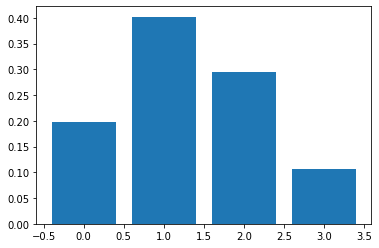

In [186]:
set_samenesses = [
    count_same_dimensions(set_) for set_ in np.concatenate(list_of_sets, axis=0)
]
set_sameness_frequency = dict(Counter(set_samenesses))
plt.bar(
    set_sameness_frequency.keys(),
    [frequency / len(set_samenesses) for frequency in set_sameness_frequency.values()],
)
plt.show()